In [157]:
!pip install -U scikit-learn
!pip install autograd

## Preliminary: the softmax function

The softmax function plays a crucial role in neural networks, particularly in the output layer of classification models. Its primary purpose is to convert a vector of real numbers into a probability distribution over multiple classes.

$$\text{Softmax}(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
 $$

First, each element of the input vector is exponentiated (raised to the power of $e$), which makes all values positive.  The exponentiation step amplifies the differences between the input values. Larger values get significantly larger, and smaller values remain relatively small. This emphasizes the model's confidence in its predictions.

After exponentiation, the softmax function normalizes the values by dividing each exponentiated value by the sum of all exponentiated values in the input vector. This step ensures that the output vector sums up to 1, making it a valid probability distribution.

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's first consider the following 2-class dataset:

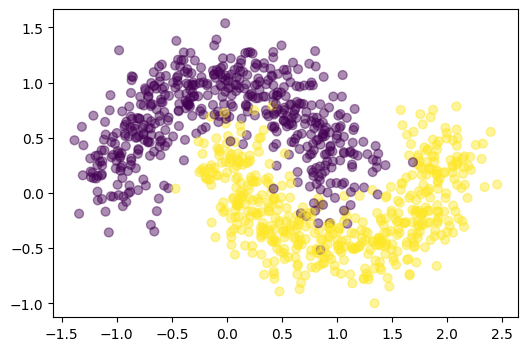

In [158]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

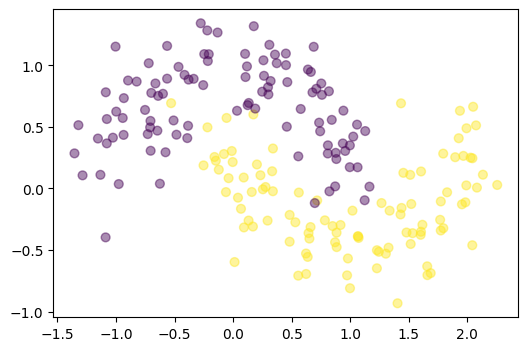

In [159]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [160]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [161]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer.

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2).
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2).

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \text{Softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network.

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$.


## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**.

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [162]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [163]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [164]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

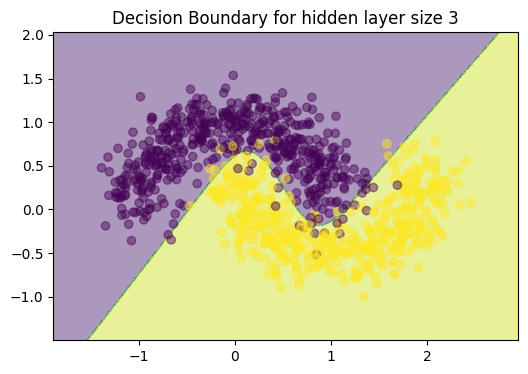

In [165]:
def plot_decision_boundary(pred_func,X,y):

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x),X,y)
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [166]:
#Accuracy using the testing dataset
y_hat = predict(model, Xt)
accuracy_1 = 1 - sum(abs(yt-y_hat))/yt.shape
print(accuracy_1)

[0.955]


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

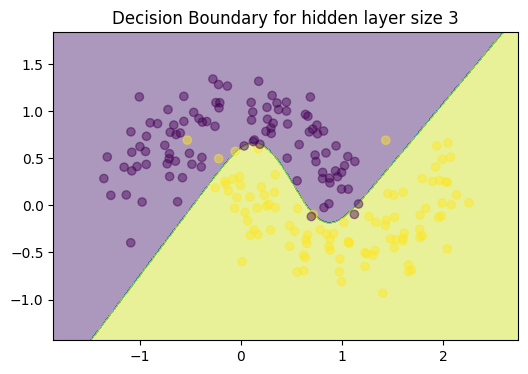

In [167]:
plot_decision_boundary(lambda x: predict(model, x),Xt,yt)
plt.title("Decision Boundary for hidden layer size 3")

Although it's a good accuracy, it could be better.

# Exercise 2

+ Add an additional layer to your neural network model.
+ Change the activation function and use a ReLU.


In [168]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
def ReLU(x): #We first define the new activaction function
  return np.maximum(0,x)

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [169]:
# We will start defining our loss function
# loss function for a 4-layer MLP
def loss2(model):

    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict2(model, x):
    W1, b1, W2, b2, W3, b3= model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


In [170]:
# This function learns parameters for the neural network and returns the model.
# - n: Number of nodes in the hidden layer
# - m: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model2(n,m, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, n) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, n))
    W2 = np.random.randn(n, m) / np.sqrt(n)
    b2 = np.zeros((1, m))
    W3 = np.random.randn(m, nn_output_dim) / np.sqrt(m)
    b3 = np.zeros((1, nn_output_dim))


    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict2(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss2)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, loss2(model)))

    return model

# Build a model with a 3-dimensional hidden layer
model = build_model2(4,5, print_loss=True)



Loss after iteration 0: 0.663236
Loss after iteration 1000: 0.331792
Loss after iteration 2000: 0.283122
Loss after iteration 3000: 0.267234
Loss after iteration 4000: 0.260448
Loss after iteration 5000: 0.255398
Loss after iteration 6000: 0.248913
Loss after iteration 7000: 0.237424
Loss after iteration 8000: 0.216483
Loss after iteration 9000: 0.185743
Loss after iteration 10000: 0.152906
Loss after iteration 11000: 0.129102
Loss after iteration 12000: 0.114346
Loss after iteration 13000: 0.106158
Loss after iteration 14000: 0.101204
Loss after iteration 15000: 0.098170
Loss after iteration 16000: 0.096212
Loss after iteration 17000: 0.094858
Loss after iteration 18000: 0.093941
Loss after iteration 19000: 0.093290
Loss after iteration 20000: 0.092810
Loss after iteration 21000: 0.092449
Loss after iteration 22000: 0.092170
Loss after iteration 23000: 0.091947
Loss after iteration 24000: 0.091764
Loss after iteration 25000: 0.091611
Loss after iteration 26000: 0.091479
Loss after ite

We try different node values in each layer, and these were some of the results

(4,4) -> 0.97 accuracy

(4,5) -> 0.98 accuracy

(5,4) -> 0.975 accuracy

(5,6) -> 0.975 accuracy

(6,6) -> 0.98 accuracy

So we decided to choose (4,5)

In [171]:
y_hat = predict2(model, Xt)
accuracy_1 = 1 - sum(abs(yt-y_hat))/yt.shape
print(accuracy_1)


[0.98]


Let's see the plot of the current situation.

Text(0.5, 1.0, 'Decision Boundary for 2-hidden layer size (4,5)')

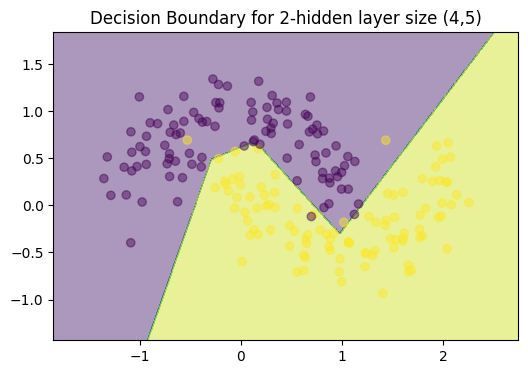

In [172]:
plot_decision_boundary(lambda x: predict2(model, x),Xt,yt)
plt.title("Decision Boundary for 2-hidden layer size (4,5)")

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset.
+ Train the model and report the classification accuracy using the testing dataset.


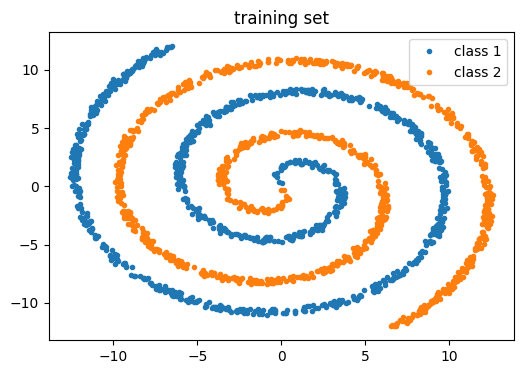

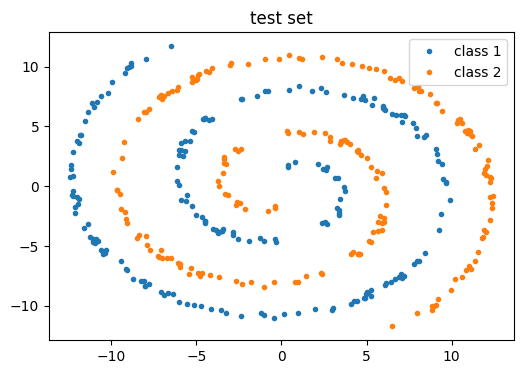

In [173]:
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.repeat(0, n_points),np.repeat(1, n_points))))

X1, y1 = twospirals(1000)

plt.title('training set')
plt.plot(X1[y1==0,0], X1[y1==0,1], '.', label='class 1')
plt.plot(X1[y1==1,0], X1[y1==1,1], '.', label='class 2')
plt.legend()
plt.show()

Xt1, yt1 = twospirals(200)

plt.title('test set')
plt.plot(Xt1[yt1==0,0], Xt1[yt1==0,1], '.', label='class 1')
plt.plot(Xt1[yt1==1,0], Xt1[yt1==1,1], '.', label='class 2')
plt.legend()
plt.show()



Let's first see our data

In [174]:
print(X1[1],X1.shape)

[-0.42800566 -4.66905164] (2000, 2)


In [182]:
print(y1[1],y1.shape)

0 (2000,)


In [176]:
num_examples = len(X1) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
def ReLU(x): #activation function
  return np.maximum(0,x)

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [177]:
# loss function for a 5-layer MLP
def loss3(model):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X1,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = ReLU(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = ReLU(z4)
    z5 = np.dot(a4,W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y1])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict3(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    z1 = np.dot(x,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = ReLU(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = ReLU(z4)
    z5 = np.dot(a4,W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [178]:
# This function learns parameters for the neural network and returns the model.
# - n: Number of nodes in the 1-hidden layer
# - m: Number of nodes in the 2-hidden layer
# - p: Number of nodes in the 3-hidden layer
# - q: Number of nodes in the 4-hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model_3(n, m, p, q, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, n) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, n))
    W2 = np.random.randn(n, m) / np.sqrt(n)
    b2 = np.zeros((1, m))
    W3 = np.random.randn(m, p) / np.sqrt(m)
    b3 = np.zeros((1, p))
    W4 = np.random.randn(p, q) / np.sqrt(p)
    b4 = np.zeros((1, q))
    W5 = np.random.randn(q, nn_output_dim) / np.sqrt(q)
    b5 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict3(model, X1)

        # computing the derivative by AD
        gradient_loss = grad(loss3)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, loss3(model)))

    return model

# Build a model with a (9,9,9,9)-dimensional 4-hidden layer
model3 = build_model_3(9, 9, 9, 9, print_loss=True)

Loss after iteration 0: 0.749483
Loss after iteration 1000: 0.661006
Loss after iteration 2000: 0.649821
Loss after iteration 3000: 0.643623
Loss after iteration 4000: 0.635416
Loss after iteration 5000: 0.626168
Loss after iteration 6000: 0.614504
Loss after iteration 7000: 0.598541
Loss after iteration 8000: 0.584717
Loss after iteration 9000: 0.556585
Loss after iteration 10000: 0.523932
Loss after iteration 11000: 0.489841
Loss after iteration 12000: 0.454458
Loss after iteration 13000: 0.422014
Loss after iteration 14000: 0.392497
Loss after iteration 15000: 0.365140
Loss after iteration 16000: 0.333288
Loss after iteration 17000: 0.174730
Loss after iteration 18000: 0.122697
Loss after iteration 19000: 0.084678
Loss after iteration 20000: 0.051032
Loss after iteration 21000: 0.035771
Loss after iteration 22000: 0.027357
Loss after iteration 23000: 0.022222
Loss after iteration 24000: 0.018754
Loss after iteration 25000: 0.016345
Loss after iteration 26000: 0.014514
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for 4-hidden layer size (9,9,9,9)')

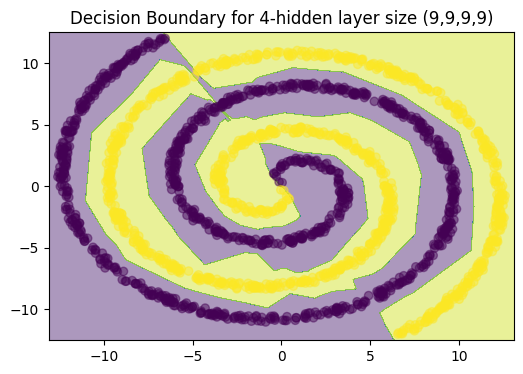

In [179]:
def plot_decision_boundary3(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary with the training set
plot_decision_boundary3(lambda x: predict3(model3, x),X1,y1)
plt.title("Decision Boundary for 4-hidden layer size (9,9,9,9)")

Again, we try different node values in each layer, and these were some of the results

(7,7,7,7) -> 0.54

(6,7,8,9) -> 0.9775

(7,7,8,8) -> 0.9375

(8,8,8,8) -> 0.9925

(9,9,9,9) -> 0.995

So we decided to choose (9,9,9,9)


In [180]:
y_hat = predict3(model3, Xt1)
accuracy_3 = 1 - sum(abs(yt1-y_hat))/yt1.shape
print(accuracy_3)


[0.995]


Let's see the final result of the classification.

Text(0.5, 1.0, 'Decision Boundary for 4-hidden layer size (9,9,9,9)')

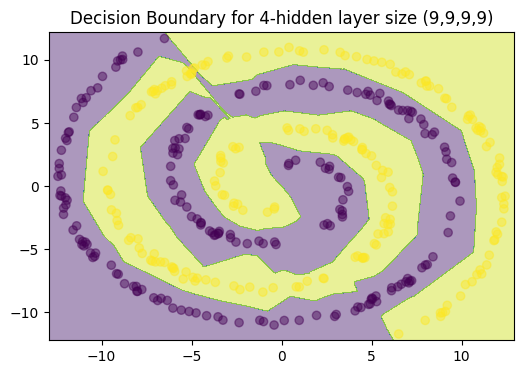

In [181]:
plot_decision_boundary3(lambda x: predict3(model3, x),Xt1,yt1)
plt.title("Decision Boundary for 4-hidden layer size (9,9,9,9)")